Example notebook for extracting resonator quality factors from complex S21 data

In [1]:
# enter the location of the data folder
# the folder must contain data files collected from measurements on the same chip
data_folder = "Y:/t1Team/Data/2024-02-29_BFG_cooldown/2023-11-30_TAHP02_Au+96nm/NFS/"

In [2]:
# IMPORTS
from rrfit.dataloader import Loader

In [3]:
# by default, the Loader will load traces of all the devices it can find in the data folder
chip = Loader(data_folder).chip  # Chip object
devices = chip.devices  # dict with key = device name and value = Device object

# do this if you want to select which devices to load
# invalid device names will be ignored
#chip = Loader(data_folder, devices=["5p95", "6p53", "invalid"]).chip
#devices = chip.devices

In [4]:
# lets start with a test trace
trace = devices["5p95"].traces[2]

In [5]:
# remove cable delay
# exclude is a tuple of ints that specify the window of data points to be excluded from cable delay fit
# exclude=None will fit the entire phase profile of the raw S21 data to a linear model
s21_cd = trace.remove_cable_delay(exclude=(30, 670))

# a future version will remove this cable delay removal step through a calibration step during data acquisition

[[Model]]
    Model(S21PhaseLinearModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 3.3642e-05
    reduced chi-square = 1.2015e-06
    Akaike info crit   = -407.027967
    Bayesian info crit = -404.225572
    R-squared          = 0.99562768
[[Variables]]
    tau:   -1.74954574 +/- 0.02191051 (1.25%) (init = -1.754686)
    theta:  65429.7616 +/- 819.398042 (1.25%) (init = 65622)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, theta) = -1.0000
[[Model]]
    Model(S21PhaseLinearModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 2.9094e-05
    reduced chi-square = 1.0391e-06
    Akaike info crit   = -411.384939
    Bayesian info crit = -408.582544
    R-squared          = 0.99650336
[[Variables]]
    tau:   -1.82016206 +/- 0.02037589 (1.12%) (in

[[Model]]
    Model(S21CenteredPhaseModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 700
    # variables        = 4
    chi-square         = 170.769278
    reduced chi-square = 0.24535816
    Akaike info crit   = -979.536860
    Bayesian info crit = -961.332539
    R-squared          = 0.96755649
##  Warning: uncertainties could not be estimated:
    fr:     at initial value
    fr:     at boundary
    sign:   at initial value
    sign:   at boundary
[[Variables]]
    fr:     5952.04970 (init = 5952.052)
    Ql:    -356625.468 (init = -79639.48)
    theta:  0.22666175 (init = 0.2644434)
    sign:         -inf (init = -inf)


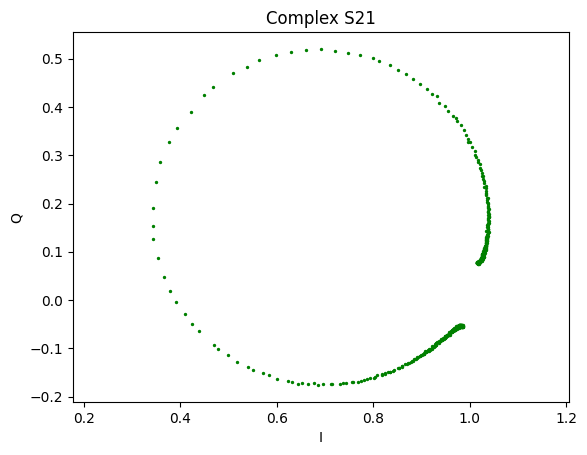

In [6]:
# subtract the background to bring s21 to the canonical position
s21_canonical = trace.remove_background()

import matplotlib.pyplot as plt
plt.gca().set(xlabel="I", ylabel="Q", title="Complex S21")
plt.gca().set_aspect("equal", "datalim")
plt.scatter(s21_canonical.real, s21_canonical.imag, s=2, c="g", label="data")


In [ ]:
# PLOTTING ROUTINES FOR EACH DEVICE
def prepare_plot():
    """ """
    fig = plt.figure(tight_layout=True, figsize=(16, 16))
    fig.suptitle("\n".join(names))
    gs = GridSpec(13, 6, figure=fig)

    # raw phase plot
    raw_phase_ax = fig.add_subplot(gs[:3, :3])
    raw_phase_ax.set(ylabel="arg(S21) (rad)", title="Raw phase")
    raw_phase_ax.locator_params(axis="both", nbins=6)


In [ ]:
# FIT ROUTINE FOR EACH DEVICE (MAIN FUNCTION)
def main(data, f):

    # transform data
    #s21mag = 20 * np.log10(np.abs(data))
    s21phase = np.unwrap(np.angle(data))

    # remove cable delay
    tau = fit_cable_delay(s21phase, f, exclude=(200, 500))
    s21 = data * np.exp(-1j * 2 * np.pi * f * tau)

    # find the off-resonant point and bring s21 to the canonical position
    orp = fit_background(s21, f)
    s21c = s21 / orp

    ## circle and phase fit to extract resonator parameters
    radius, center = fit_circle(s21c)
    cx, cy = center.real, center.imag

    s21cphase = np.unwrap(np.angle((s21 - center)))
    model = S21CenteredPhaseModel()
    result = model.fit(s21cphase, f)

    fr = result.best_values["fr"]
    Ql = result.best_values["Ql"]

    # must be -np.arcsin((orp.imag - center.imag) / radius) if orp is not ideal
    phi = -np.arcsin(center.imag / radius)

    Qc = Ql / (2 * radius * np.exp(-1j * phi))  # 1 for reflection and 2 for hanger mode
    absQc = np.abs(Qc)
    Qi = 1 / ((1 / Ql) - (1 / Qc.real))

    plt.cla()
    plt.gca().set(xlabel="I", ylabel="Q", title="Complex S21")
    plt.gca().set_aspect("equal", "datalim")
    plt.scatter(s21c.real, s21c.imag, s=2, c="g", label="data")
    # plt.plot([orp.real], [orp.imag], "o", ms=8, c="k")
    # plt.plot([rp.real], [rp.imag], "o", ms=8, c="r")
    plt.plot([cx], [cy], "o", ms=8, c="g")
    circle = plt.Circle((cx, cy), radius, ec="r", ls="--", fill=False, label="fit")
    plt.gca().add_patch(circle)
    plt.legend()

    print(Qi)
    print(phi)
    print(absQc)
    print(Ql)
    print(fr)


In [ ]:
# LOAD AND FIT DATA (ENTRY POINT TO MAIN FUNCTION)
for file_path in Path(data_location).iterdir():

    if file_path.suffix == ".pickle":
        file_name = file_path.stem
        with open(file_path, "rb") as file:
            data = pickle.load(file)
        device_names = data["inputDict"]["names"]

        if file_name == "data-2023-11-11-15-42-38":
            for i, dev_name in enumerate(device_names):
                if not i:
                    f = np.array(data["data"]["f"][i])
                    I = np.array(data["data"]["IArray"][i])
                    Q = np.array(data["data"]["QArray"][i])
                    s21 = I + 1j * Q
                    main(s21, f)
